In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata
import seaborn as sb
import matplotlib.pyplot as plt
import scvi

import scrublet as scr

# import UMIs

In [2]:
file_list = ["AB3119.txt", "AB3124.txt", "AB3146.txt",  "AB3151.txt", "AB3156.txt", "AB3115.txt", "AB3120.txt", "AB3125.txt", 
 "AB3147.txt", "AB3152.txt", "AB3157.txt","AB3116.txt", "AB3121.txt", "AB3126.txt", "AB3148.txt", "AB3153.txt",
 "AB3117.txt",  "AB3122.txt", "AB3144.txt", "AB3149.txt", "AB3154.txt", "AB3118.txt", "AB3123.txt", "AB3145.txt", 
 "AB3150.txt", "AB3155.txt"]

In [3]:
dataset_list = []
umi_tabs_order = []
for file in file_list:
    local_dataset = pd.read_csv(file, sep="\t").T
    dataset_list.append(local_dataset)
    umi_tabs_order.append(local_dataset.index.values)
dataset = pd.concat(dataset_list)

In [4]:
adata = anndata.AnnData(dataset)

In [5]:
AB_file = []
for obs in dataset.index.values:
    AB_file.append(np.array(file_list)[np.array([obs in x for x in umi_tabs_order])][0])
adata.obs["ABfile"] = AB_file

In [6]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=100)

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [8]:
adata.obs

,ABfile,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
W1223001,AB3119.txt,5823.0,1367,5823.0,125.0,2.146660
W1223002,AB3119.txt,220.0,140,220.0,68.0,30.909092
W1223003,AB3119.txt,2934.0,922,2934.0,176.0,5.998637
W1223004,AB3119.txt,1999.0,760,1999.0,95.0,4.752376
W1223005,AB3119.txt,3849.0,1084,3849.0,73.0,1.896597
...,...,...,...,...,...,...
W1237203,AB3155.txt,484.0,332,484.0,9.0,1.859504
W1237204,AB3155.txt,496.0,313,496.0,13.0,2.620968
W1237205,AB3155.txt,458.0,296,458.0,20.0,4.366812
W1237207,AB3155.txt,301.0,199,301.0,5.0,1.661129


... storing 'ABfile' as categorical


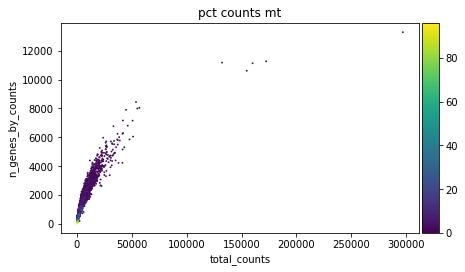

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


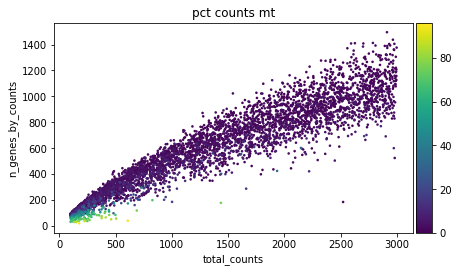

In [9]:
#Data quality summary plots; 
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')
sc.pl.scatter(adata[adata.obs['total_counts']<3000], 'total_counts', 'n_genes_by_counts', color='pct_counts_mt')

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


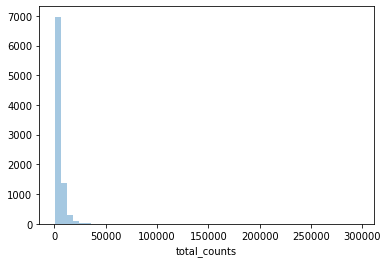

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


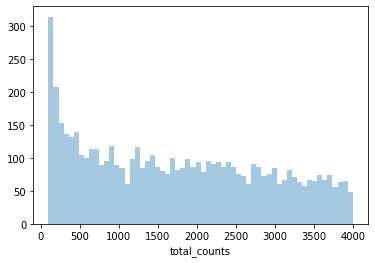

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


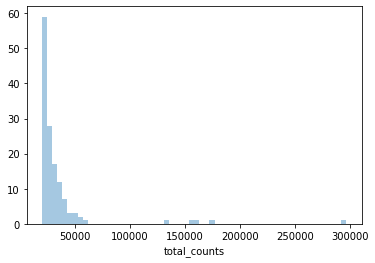

In [10]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['total_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>20000], kde=False, bins=60)
plt.show()

In [11]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 200)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 70000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

# adata = adata[adata.obs['pct_counts_mt'] < 20]
# print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 8823


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 8396
Number of cells after max count filter: 8391


In [12]:
# filtering additional barcodes based on external analysis (meta-cell)
barcodes_interest = np.load("selected_barcodes.npy", allow_pickle=True)
adata = adata[barcodes_interest].copy()

# import annotation
These labels are based on a different analysis (metacell), and are merely used for sanity check.

In [13]:
annotation = pd.read_excel("for_Romain_2.xlsx", index_col=0)

In [14]:
annotation["Cell type"]

cell ID
W1094666          Treg
W1094668     CD8 Isg20
W1094669           CD4
W1094670    CD4 Ifitm3
W1094671     CD8 Crip1
               ...    
W1237972      Mac C1qa
W1237973       Mon-Mac
W1237974      Mon Lyz2
W1237975      Mon Lyz2
W1237976      Mac C1qa
Name: Cell type, Length: 35816, dtype: object

In [15]:
labels = []
for cell in range(adata.n_obs):
    if adata.obs.index[cell] in annotation.index:
        labels.append(annotation.loc[adata.obs.index[cell]]["Cell type"])
    else:
        labels.append("NA")

In [16]:
adata.obs["labels"] = labels

### preprocessing

In [14]:
# let us filter some genes
G = 4000
sc.pp.filter_genes(adata, min_counts=10)

adata.layers["counts"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [15]:
# doublet detection
X = adata.layers["counts"]
# run scrublet 
doublet_scores, doublet_predictions = scr.Scrublet(X).scrub_doublets()
adata.obs["doublet_scores"] = doublet_scores

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 6.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 5.5 seconds


## layout cells

In [16]:
scvi.data.setup_anndata(adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Successfully registered anndata object containing 7185 cells, 4000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [17]:
train = False
if train:
    sc_model = scvi.model.SCVI(adata, n_latent=20)
    sc_model.train(max_epochs=250)
    sc_model.save("SCVI", overwrite=True)
else:
    sc_model = scvi.model.SCVI.load("SCVI", adata, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 7185 cells, 4000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
adata.obsm["X_scVI"] = sc_model.get_latent_representation(adata)

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_scVI")
sc.tl.umap(adata)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [20]:
sc.tl.leiden(adata, key_added="leiden", resolution=0.5, random_state=0)
sc.tl.leiden(adata, restrict_to = ("leiden", ["1"]), key_added="leiden_2", resolution=0.3, random_state=0)

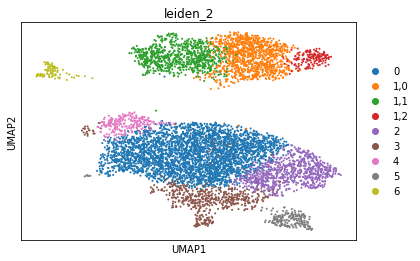

In [21]:
sc.pl.umap(adata, color="leiden_2")

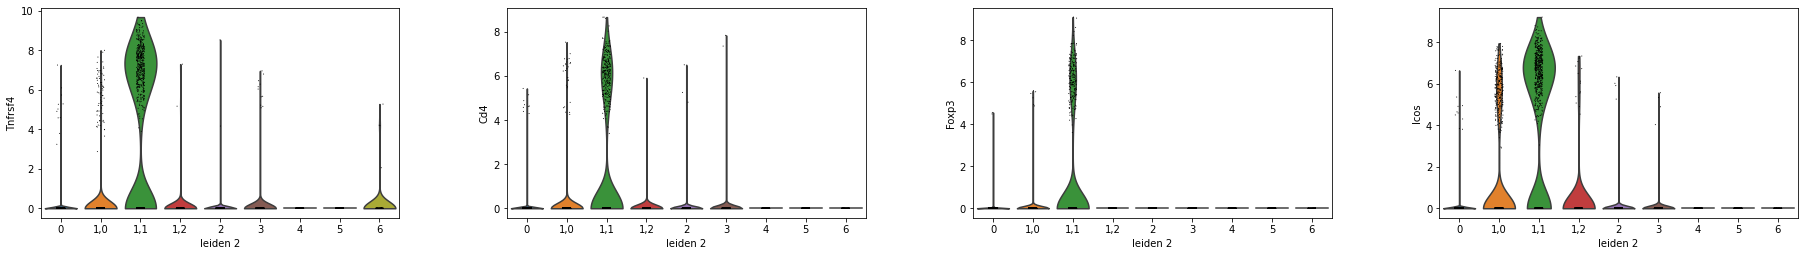

In [23]:
# Marker genes below come from an orthogonal analysis, we used them to identify the clusters from scVI
# CD4 Ifitm3,Tnfrsf4,S100a4,Crip1,Cd4,Ifitm2,S100a10,Icos,Lgals1,
# CD4,Ramp3,Tnfrsf4,Emb,Il7r,Fos,Cd4,Rgs2,,
# CD4 Isg20,Slfn5,Ifit3,Ifit1,Isg20,Gbp2,Isg15,Samhd1,Ifitm3,
# Treg,Tnfrsf4,Il2ra,Tnfrsf9,Gzmb,Ikzf2,Foxp3,Tnfrsf18,Icos,

sc.pl.violin(adata, ['Tnfrsf4', 'Cd4', "Foxp3", "Icos"], groupby='leiden_2')

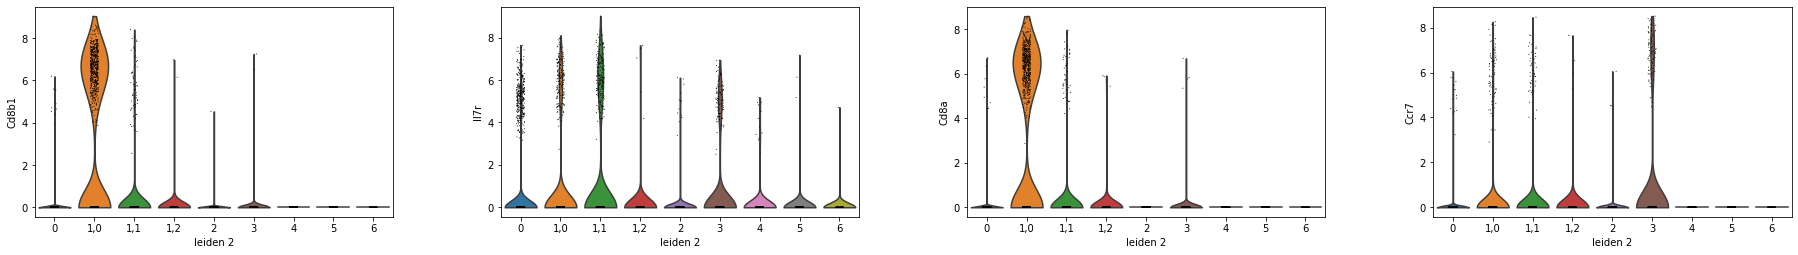

In [25]:
# CD8 Npm1,Ly6c2,Xcl1,Cd8a,Gzmb,Cd8b1,Nhp2,Ranbp1,Eif5a,Npm1
# CD8 Il7r,Ccr7,Il7r,Sell,Cd8b1,Txk,Tcf7,Gm14303,Gm2000,
# CD8 Isg20,Ccl5,Gzma,Gzmb,Cd8b1,Cd8a,Ly6c2,Gzmk,Ifit3,
# CD8 Crip1,Cd8b1,Cd8a,Ly6c2,Ccl5,Nkg7,Gzmb,Klrk1,Gzmk,
# CD8 Ikzf2,Ly6c2,Ccl5,Fcer1g,Sell,Bcl2,Gm10275,Gm2000,Klra7,

sc.pl.violin(adata, ['Cd8b1', "Il7r", "Cd8a", "Ccr7"], groupby='leiden_2')

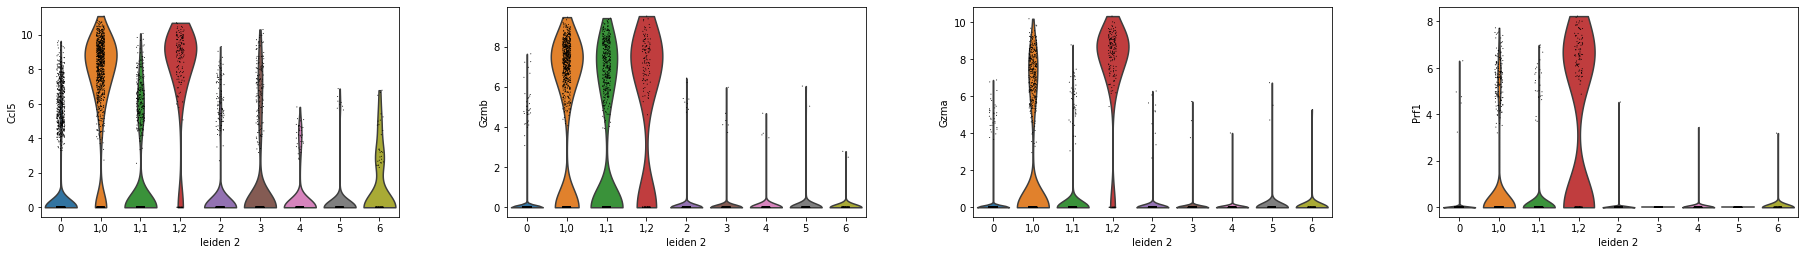

In [26]:
# NK,Fcer1g,Ly6c2,Xcl1,Gzmb,Klrk1,Gzma,Klrb1c,Klra1,
sc.pl.violin(adata, ['Ccl5', "Gzmb", "Gzma", "Prf1"], groupby='leiden_2')

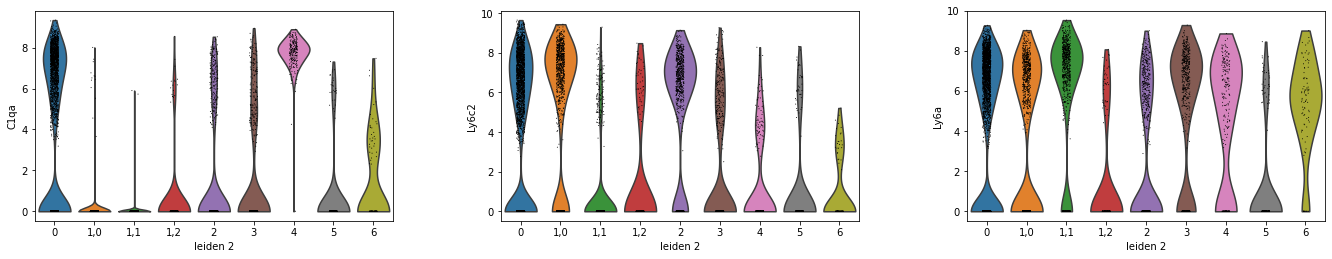

In [27]:
# Mac C1qa,C1qa,C1qb,C1qc,Apoe,Pf4,Fcrls,Ms4a7,Ccl12,
# Mon Lyz2,Plac8,Ly6c2,Chil3,Wfdc17,Gbp2,Samhd1,Sell,Cxcl10,
# Mon C1qa,C1qb,C1qa,C1qc,H2-Ab1,Arg1,H2-Eb1,H2-Aa,Cd74,
# Mon Clec7a,Arg1,Tgm2,Thbs1,Fn1,Chil3,Il1b,Ly6c2,Cd14,
# Mac Arg1,Pf4,Arg1,Spp1,Apoe,Ctsl,Fn1,Thbs1,Ms4a7,
# Mon-Mac,Ly6c2,Ly6a,Ms4a4c,Ifit3,AW112010,Plac8,Rsad2,Irf7,

sc.pl.violin(adata, ['C1qa', "Ly6c2", "Ly6a"], groupby='leiden_2')

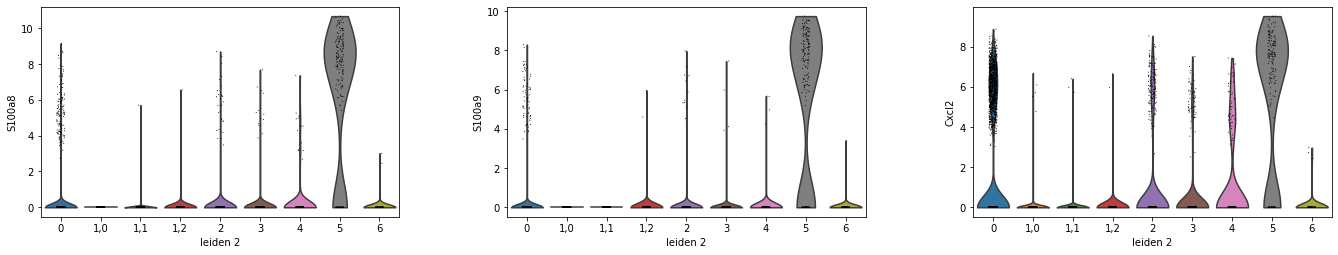

In [28]:
# Neutrophil,S100a8,S100a9,Cxcl2,Il1b,Acod1,G0s2,Hdc,Il1rn,

sc.pl.violin(adata, ['S100a8', "S100a9", "Cxcl2"], groupby='leiden_2')

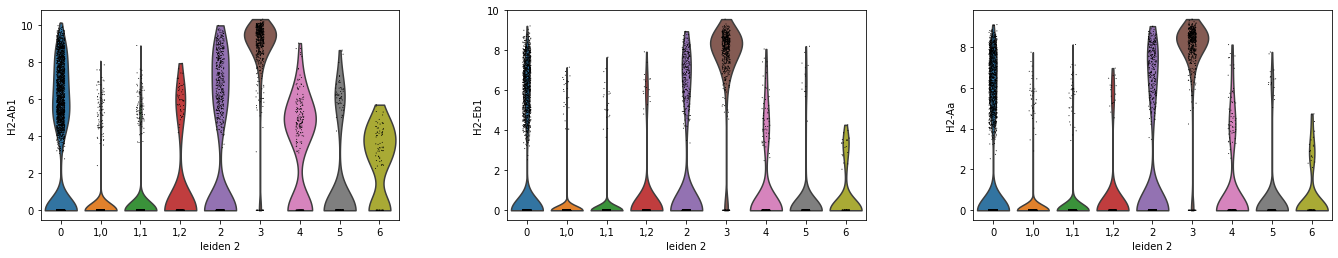

In [29]:
# DC,H2-Ab1,H2-Eb1,H2-Aa,Cd74,Syngr2,Ifitm1,Mir5107,Cst3,

sc.pl.violin(adata, ['H2-Ab1', "H2-Eb1", "H2-Aa"], groupby='leiden_2')

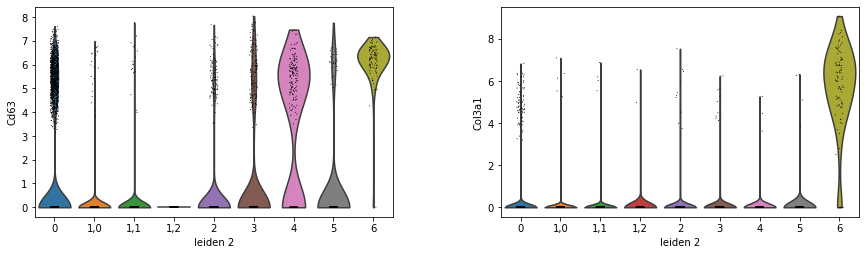

In [30]:
# Tumor,Ctsk,Mmp9,Acp5,Cd63,Cd63-ps,Lmna,Atp6v0d2,Slc25a4,

sc.pl.violin(adata, ['Cd63', "Col3a1"], groupby='leiden_2')

In [22]:
mapping = {"Macrophages": ["0", "2", "4"], 
           "CD4 T cells": ["1,1"],
           "CD8 T cells": ["1,0"],
           "DCs": ["3"],
           "Neutrophils": ["5"],
           "Tumor": ["6"],
           "NK cells": ["1,2"]
          }

res = []
for cluster in adata.obs["leiden_2"]:
    local = "NA"
    for k, v in mapping.items():
        if cluster in v:
            local = k
    res.append(local)
    
adata.obs["broad_labels"] = res

... storing 'broad_labels' as categorical


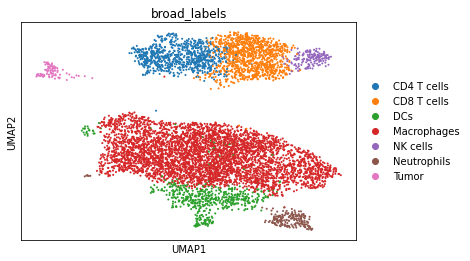

In [23]:
sc.pl.umap(adata, color="broad_labels")

In [24]:
adata.write("tumor_sc.h5ad")